In [16]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\Ferna\AppData\Local\Temp\ipykernel_25660\2883114424.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD )
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Average_Price,Money_Flow,Pos_Flow,Neg_Flow,MFI,MFI_Strategy,RSI,RSI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
13,24.085649,24.380434,23.756184,24.380434,378100,24.074089,9.102413e+06,0.000000e+00,9.102413e+06,65.783598,0.0,41.747614,0.0,0.0,0,-0.012091,0.000000
14,24.172350,24.172350,24.050968,24.085649,34900,24.131889,8.422029e+05,8.422029e+05,0.000000e+00,66.049615,-1.0,44.444444,0.0,-1.0,0,-0.008535,0.000000
15,24.259052,24.293733,24.172351,24.241712,513600,24.241712,1.245054e+07,1.245054e+07,0.000000e+00,66.260600,-1.0,41.747303,0.0,-1.0,0,-0.004979,0.000000
16,24.241718,24.345760,24.120336,24.328420,373700,24.235938,9.056970e+06,0.000000e+00,9.056970e+06,59.479955,-1.0,39.603688,0.0,-1.0,0,-0.005690,0.000000
17,24.553846,24.553846,24.259061,24.259061,26300,24.455585,6.431819e+05,6.431819e+05,0.000000e+00,54.454537,0.0,41.346093,0.0,0.0,0,0.007113,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8155,606.780029,607.849976,603.409973,604.330017,67735300,606.013326,4.104849e+10,4.104849e+10,0.000000e+00,58.795805,0.0,62.793405,0.0,0.0,0,23.887991,2.365667
8156,607.119995,608.609985,605.539978,607.909973,62114800,607.089986,3.770927e+10,3.770927e+10,0.000000e+00,59.032178,0.0,63.257648,0.0,0.0,0,23.901935,2.365667
8157,611.869995,612.309998,608.369995,608.989990,78548400,610.849996,4.798129e+10,4.798129e+10,0.000000e+00,67.340703,0.0,70.282021,0.0,0.0,0,24.096764,2.365667
8158,614.909973,616.390015,610.830017,612.880005,86258400,614.043335,5.296640e+10,5.296640e+10,0.000000e+00,68.016118,-1.0,68.391896,-1.0,-2.0,-1,24.221453,2.348945


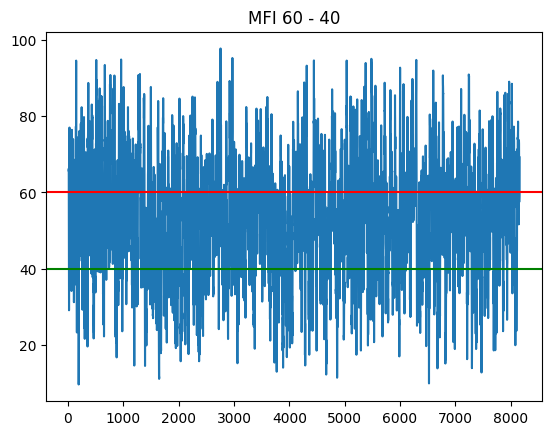

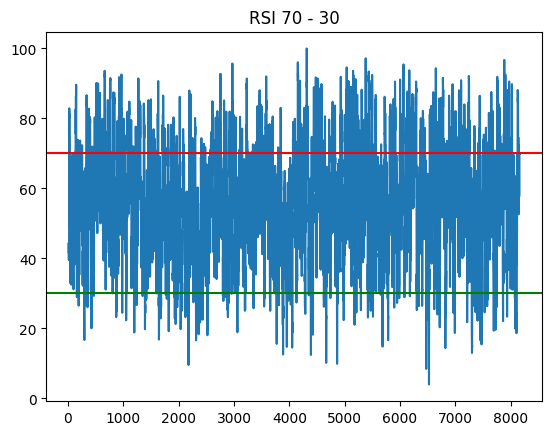

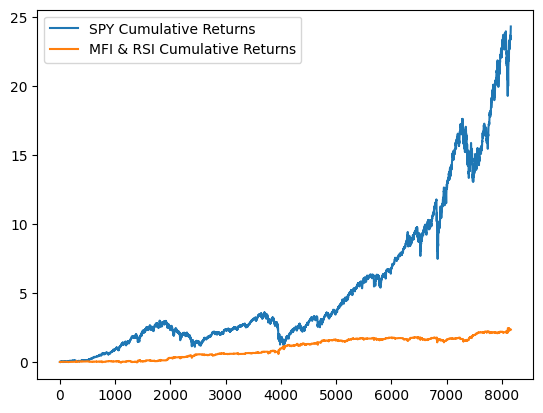

In [17]:
TICKER = 'SPY'
INTERVAL = '1d'
LEVERAGE = 1

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

# MFI parameters
MFI_LENGHT = 14
MFI_OVERBOUGHT = 60
MFI_OVERSOLD = 40

# RSI parameters
RSI_LENGHT = 14
RSI_OVERBOUGHT = 70 
RSI_OVERSOLD = 30

# subsection of data we are interested
LOOKBACK = 10000

def get_data(ticker = TICKER, lookback = LOOKBACK, interval = INTERVAL):

    # get data at interval
    df = yf.download(ticker, interval = interval, period = PERIOD ) 
    df.columns = df.columns.get_level_values(0)

    df = df.reset_index(drop = True) # Changes dates to numbers so we don't have weird weekend gaps when plotting

    return df.iloc[-lookback:,:] #Take a piece of the last "LOOKBACK" rows

def add_MFI(df, lenght = MFI_LENGHT):

    #Typical/Average Price
    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']

    #initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Money_Flow'], 0)

    mfr = df['Pos_Flow'].rolling(lenght).sum() / df['Neg_Flow'].rolling(lenght).sum()
    df['MFI'] = 100 - (100 / (1 + mfr))

    return df

def add_MFI_strategy(df, overbought = MFI_OVERBOUGHT, oversold = MFI_OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, np.where(df['MFI'] < oversold, 1, 0))
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)

    plt.plot(df['MFI'])
    plt.axhline(overbought, color = 'red')
    plt.axhline(oversold, color = 'green')
    plt.title(f'MFI {MFI_OVERBOUGHT} - {MFI_OVERSOLD}')

    return df

def add_RSI(df, lenght = RSI_LENGHT, overbought = RSI_OVERBOUGHT, oversold = RSI_OVERSOLD):

    price_change = df['Close'].diff() #diff() => current value - previous value

    # Separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = - price_change.where(price_change < 0, 0)

    # Average gain vs loss
    avg_gain = gain.rolling(window = lenght).mean()
    avg_loss = loss.rolling(window = lenght).mean()

    # Calculate RSI
    rs = avg_gain/avg_loss # what % of the avg loss is the avg gain
    rsi = 100 - (100/(1 + rs))

    df['RSI'] = rsi

    # plot the RSI
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(overbought, color = 'red')
    plt.axhline(oversold, color = 'green') 
    plt.title(f'RSI {RSI_OVERBOUGHT} - {RSI_OVERSOLD}')

    return df

def add_RSI_strategy(df, overbought = RSI_OVERBOUGHT, oversold = RSI_OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, np.where(df['RSI'] < oversold, 1, 0))
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)

    return df

def add_full_strategy(df, leverage = LEVERAGE):
    df['Full_Strategy'] = df['MFI_Strategy'] + df['RSI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, leverage, np.where(df['Full_Strategy'] == -2, -leverage, 0))

    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])

    plt.legend([f'{TICKER} Cumulative Returns', f'MFI & RSI Cumulative Returns'])

    return df

def main():
    df = get_data()
    df = add_MFI(df)
    df = add_MFI_strategy(df)
    df = add_RSI(df)
    df = add_RSI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df.dropna()

df = main()
df